<a href="https://colab.research.google.com/github/ada-my619/Seismic_Facies_Interpretation/blob/main/Seismic_Facies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycm livelossplot
%pylab inline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary


import matplotlib.pyplot as plt
import numpy as np
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.4/610.4 kB 23.8 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [2]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [3]:
set_seed(42)

True

In [4]:
# download the files:
#!wget https://zenodo.org/record/3755060/files/data.zip
# check that the md5 checksum matches:
#!openssl dgst -md5 data.zip # Make sure the result looks like this: MD5(data.zip)= bc5932279831a95c0b244fd765376d85, otherwise the downloaded data.zip is corrupted.
# unzip the data:
#!unzip data.zip
# create a directory where the train/val/test splits will be stored:
#!mkdir data/splits

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# !cp ./data.zip /content/drive/MyDrive/data.zip

In [7]:
!ls -lh /content/drive/MyDrive/

total 1003M
drwx------ 2 root root  4.0K Nov 26 11:23 'Colab Notebooks'
-rw------- 1 root root 1003M Dec 30 21:53  data.zip
-rw------- 1 root root    67 Nov 25 17:01  kaggle.json
drwx------ 2 root root  4.0K Nov 26 14:28  models
drwx------ 2 root root  4.0K Dec 30 21:34  seismic_project


In [8]:
!cp /content/drive/MyDrive/data.zip .

In [9]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/train/
  inflating: data/train/train_seismic.npy  
  inflating: data/train/train_labels.npy  
   creating: data/test_once/
  inflating: data/test_once/test1_seismic.npy  
  inflating: data/test_once/test2_labels.npy  
  inflating: data/test_once/test1_labels.npy  
  inflating: data/test_once/test2_seismic.npy  
  inflating: data/.dropbox           


In [10]:
from matplotlib import pyplot as plt
import numpy as np

train_seismic = np.load('data/train/train_seismic.npy')
train_labels = np.load('data/train/train_labels.npy')
train_seismic.shape, train_labels.shape

((401, 701, 255), (401, 701, 255))

In [11]:
class SeismicSliceDataset(Dataset):
    def __init__(self, seismic_path, labels_path, axis=0, transform=None):
        self.seis = np.load(seismic_path)   # memory-friendly
        self.lab  = np.load(labels_path)
        assert self.seis.shape == self.lab.shape
        self.axis = axis
        self.transform = transform

        self.n = self.seis.shape[axis]  # number of slices

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        # take a slice along chosen axis
        x = np.take(self.seis, idx, axis=self.axis)  # (401,701) if axis=2
        y = np.take(self.lab,  idx, axis=self.axis)

        # convert types
        x = torch.from_numpy(np.array(x)).float().unsqueeze(0)  # (1,H,W)
        y = torch.from_numpy(np.array(y)).long()               # (H,W) for CE loss

        if self.transform:
            x, y = self.transform(x, y)

        return x, y

In [12]:
# import numpy as np
# import torch
# from torch.utils.data import Dataset

# class SeismicSliceDataset(Dataset):
#     def __init__(self, seismic_paths, labels_paths=None, axis=0, transform=None, mmap_mode="r"):
#         """
#         seismic_paths: str or list[str]
#         labels_paths : str or list[str] or None
#         axis         : slice axis
#         transform    : optional callable (x, y) -> (x, y) or (x) -> x if labels_paths is None
#         mmap_mode    : "r" to memory-map (recommended for big .npy)
#         """
#         # allow passing a single string
#         if isinstance(seismic_paths, str):
#             seismic_paths = [seismic_paths]
#         if labels_paths is not None and isinstance(labels_paths, str):
#             labels_paths = [labels_paths]

#         self.seis_list = [np.load(p, mmap_mode=mmap_mode) for p in seismic_paths]

#         if labels_paths is not None:
#             assert len(labels_paths) == len(seismic_paths), "labels_paths must match seismic_paths length"
#             self.lab_list = [np.load(p, mmap_mode=mmap_mode) for p in labels_paths]
#             for s, l in zip(self.seis_list, self.lab_list):
#                 assert s.shape == l.shape, f"Seismic and label shapes differ: {s.shape} vs {l.shape}"
#         else:
#             self.lab_list = None

#         self.axis = axis
#         self.transform = transform

#         # number of slices per volume along chosen axis
#         self.ns = [arr.shape[axis] for arr in self.seis_list]

#         # cumulative offsets so we can map global idx -> (volume_id, local_idx)
#         self.cum = np.cumsum([0] + self.ns)  # e.g., [0, n0, n0+n1, ...]

#     def __len__(self):
#         return int(self.cum[-1])

#     def _locate(self, idx):
#         # find which volume idx falls into
#         vol_id = int(np.searchsorted(self.cum, idx, side="right") - 1)
#         local_idx = int(idx - self.cum[vol_id])
#         return vol_id, local_idx

#     def __getitem__(self, idx):
#         vol_id, local_idx = self._locate(idx)

#         x_np = np.take(self.seis_list[vol_id], local_idx, axis=self.axis)
#         x = torch.from_numpy(np.array(x_np)).float().unsqueeze(0)  # (1,H,W)

#         if self.lab_list is not None:
#             y_np = np.take(self.lab_list[vol_id], local_idx, axis=self.axis)
#             y = torch.from_numpy(np.array(y_np)).long()            # (H,W)
#             if self.transform:
#                 x, y = self.transform(x, y)
#             return x, y
#         else:
#             if self.transform:
#                 x = self.transform(x)
#             return x


In [48]:
import numpy as np
import torch
from torch.utils.data import Dataset

class SeismicSliceDataset(Dataset):
    def __init__(self, seismic_path, labels_path, axis=0, transform=None, mode="single", mmap_mode="r"):
        """
        mode:
          - "single": behave exactly like your original class (uses `axis`)
          - "both":  return inline and crossline slices (axis is ignored)
                    inline  => seis[i, :, :]  (X, T)
                    xline   => seis[:, x, :]  (I, T)
        """
        self.seis = np.load(seismic_path, mmap_mode=mmap_mode)
        self.lab  = np.load(labels_path,  mmap_mode=mmap_mode)
        assert self.seis.shape == self.lab.shape

        self.axis = axis
        self.transform = transform
        self.mode = mode

        I, X, T = self.seis.shape
        self.I, self.X, self.T = I, X, T

        if self.mode == "single":
            self.n = self.seis.shape[self.axis]
            self.index_map = None
        elif self.mode == "both":
            # build index list of (direction, index)
            # 'i' means inline index in [0..I-1]
            # 'x' means crossline index in [0..X-1]
            self.index_map = [("i", i) for i in range(I)] + [("x", x) for x in range(X)]
            self.n = len(self.index_map)
        else:
            raise ValueError("mode must be 'single' or 'both'")

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        if self.mode == "single":
            # original behavior
            x = np.take(self.seis, idx, axis=self.axis)
            y = np.take(self.lab,  idx, axis=self.axis)

        else:
            # mode == "both"
            direction, k = self.index_map[idx]

            if direction == "i":        # inline slice
                x = self.seis[k, :, :]  # (X, T)
                y = self.lab[k, :, :]
            else:                       # crossline slice
                x = self.seis[:, k, :]  # (I, T)
                y = self.lab[:, k, :]

        # convert types
        x = torch.from_numpy(np.array(x)).float().unsqueeze(0)  # (1,H,W)
        y = torch.from_numpy(np.array(y)).long()                # (H,W)

        if self.transform:
            x, y = self.transform(x, y)

        # OPTIONAL: return direction for debugging/sampler (recommended)
        if self.mode == "both":
            return x, y, direction

        return x, y


In [49]:
import random
import torch
import torchvision.transforms.functional as TF

class JointCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x, y):
        for t in self.transforms:
            x, y = t(x, y)
        return x, y


class RandomRotate:
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, x, y):
        angle = random.uniform(-self.degrees, self.degrees)
        # rotate x (float image)
        x = TF.rotate(x, angle)
        # rotate y (label) as image with nearest interpolation
        y = TF.rotate(y.unsqueeze(0).float(), angle, interpolation=TF.InterpolationMode.NEAREST).squeeze(0).long()
        return x, y


class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, x, y):
        if random.random() < self.p:
            x = TF.hflip(x)
            y = TF.hflip(y)
        return x, y


class GaussianBlurXOnly:
    def __init__(self, kernel_size=3, sigma=None, p=1.0):
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.p = p

    def __call__(self, x, y):
        if random.random() < self.p:
            x = TF.gaussian_blur(x, kernel_size=self.kernel_size, sigma=self.sigma)
        return x, y


class AddNoiseXOnly:
    def __init__(self, std=0.01, p=0.5):
        self.std = std
        self.p = p

    def __call__(self, x, y):
        if random.random() < self.p:
            x = x + torch.randn_like(x) * self.std
        return x, y


In [50]:
transform = JointCompose([
    RandomRotate(10),
    RandomHorizontalFlip(p=0.5),
    GaussianBlurXOnly(kernel_size=3, p=0.3),
    AddNoiseXOnly(std=0.01, p=0.5),
])

train_dataset = SeismicSliceDataset(seismic_path='data/train/train_seismic.npy', labels_path='data/train/train_labels.npy', transform=transform, mode="both")
train_dataset

In [51]:
len(train_dataset)

1102

In [52]:
train_dataset[0][0].shape

torch.Size([1, 701, 255])

i


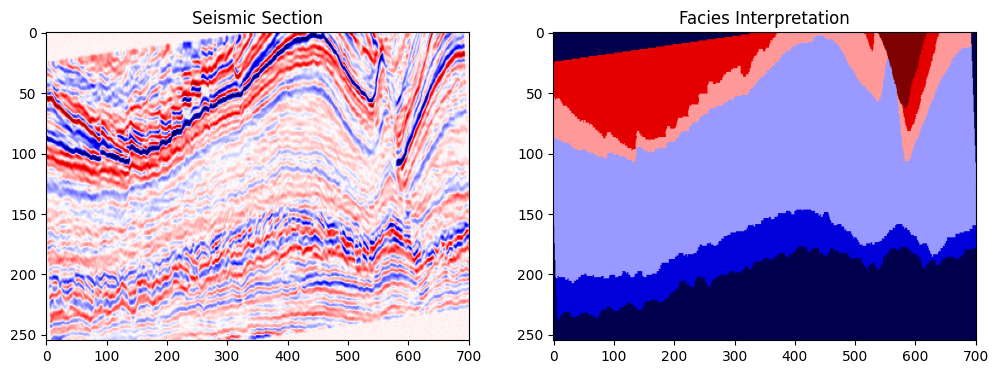

In [53]:
x, y, d = train_dataset[0]
print(d)
fig = plt.figure(figsize=(12, 4))

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(x.permute(2, 1, 0).numpy(), cmap='seismic', aspect='auto')
ax1.set_title('Seismic Section')

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(y.permute(1, 0).numpy(), cmap='seismic', aspect='auto')
ax2.set_title('Facies Interpretation')

plt.show()

In [62]:
import random
from torch.utils.data import Subset

def split_indices_by_direction(base_dataset, val_frac=0.2, seed=42):
    assert hasattr(base_dataset, "index_map") and base_dataset.index_map is not None, \
        "base_dataset must be created with mode='both'"

    rng = random.Random(seed)

    inline_ids = [i for i, (d, _) in enumerate(base_dataset.index_map) if d == "i"]
    cross_ids  = [i for i, (d, _) in enumerate(base_dataset.index_map) if d == "x"]

    rng.shuffle(inline_ids)
    rng.shuffle(cross_ids)

    n_val_i = int(len(inline_ids) * val_frac)
    n_val_x = int(len(cross_ids)  * val_frac)

    val_indices   = inline_ids[:n_val_i] + cross_ids[:n_val_x]
    train_indices = inline_ids[n_val_i:] + cross_ids[n_val_x:]

    rng.shuffle(train_indices)
    rng.shuffle(val_indices)

    return train_indices, val_indices


In [54]:
# from torch.utils.data import Subset

# n_total = len(train_dataset)
# split_idx = int(0.8 * n_total)

# train_indices = list(range(0, split_idx))
# val_indices   = list(range(split_idx, n_total))

# train_ds = Subset(train_dataset, train_indices)
# val_ds   = Subset(train_dataset, val_indices)

In [63]:
train_indices, val_indices = split_indices_by_direction(train_dataset, val_frac=0.2, seed=42)

train_ds = Subset(train_dataset, train_indices)
val_ds   = Subset(train_dataset, val_indices)

torch.Size([1, 701, 255])
torch.Size([701, 255])
i


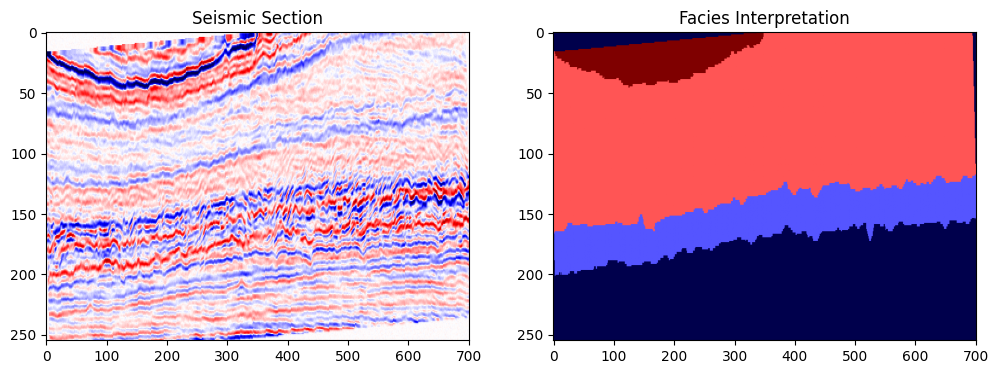

In [64]:
x, y,d = train_ds[0]
print(x.shape)
print(y.shape)
print(d)
fig = plt.figure(figsize=(12, 4))

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(x.permute(2, 1, 0).numpy(), cmap='seismic', aspect='auto')
ax1.set_title('Seismic Section')

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(y.permute(1, 0).numpy(), cmap='seismic', aspect='auto')
ax2.set_title('Facies Interpretation')

plt.show()

In [115]:
from torch.utils.data import Sampler, Subset
import random

class DirectionBatchSampler(Sampler):
    """
    Works with:
      - a base dataset (must have .index_map)
      - a torch.utils.data.Subset of that dataset

    Guarantees each batch is 'i' only or 'x' only.
    """

    def __init__(self, ds_or_subset, batch_size, shuffle=True, seed=42):
        self.ds = ds_or_subset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.rng = random.Random(seed)

        # Detect Subset vs base dataset
        if isinstance(ds_or_subset, Subset):
            self.is_subset = True
            base = ds_or_subset.dataset
            base_indices = list(ds_or_subset.indices)  # indices into base dataset
        else:
            self.is_subset = False
            base = ds_or_subset
            base_indices = list(range(len(ds_or_subset)))  # indices into base dataset (itself)

        if not hasattr(base, "index_map") or base.index_map is None:
            raise ValueError("Base dataset must have index_map (create dataset with mode='both').")

        # Group positions by direction.
        # IMPORTANT:
        # - if Subset: yield positions in subset (0..len(subset)-1)
        # - else: yield base indices directly
        self.inline_ids = []
        self.cross_ids = []

        for pos, base_idx in enumerate(base_indices):
            d, _ = base.index_map[base_idx]
            yield_id = pos if self.is_subset else base_idx

            if d == "i":
                self.inline_ids.append(yield_id)
            else:
                self.cross_ids.append(yield_id)

    def __iter__(self):
        inline = self.inline_ids.copy()
        cross  = self.cross_ids.copy()

        if self.shuffle:
            self.rng.shuffle(inline)
            self.rng.shuffle(cross)

        inline_batches = [inline[i:i+self.batch_size] for i in range(0, len(inline), self.batch_size)]
        cross_batches  = [cross[i:i+self.batch_size]  for i in range(0, len(cross),  self.batch_size)]

        all_batches = inline_batches + cross_batches
        if self.shuffle:
            self.rng.shuffle(all_batches)

        for b in all_batches:
            yield b

    def __len__(self):
        return (len(self.inline_ids) + len(self.cross_ids)) // self.batch_size


In [116]:
batch_size = 8

In [118]:
sampler_train = DirectionBatchSampler(
    train_ds,
    batch_size=batch_size,
    shuffle=True
)

sampler_val = DirectionBatchSampler(
    val_ds,
    batch_size=batch_size,
    shuffle=False
)

train_loader = DataLoader(dataset=train_ds, batch_sampler=sampler_train, num_workers=2)
val_loader   = DataLoader(dataset=val_ds, batch_sampler=sampler_val, num_workers=2)

In [119]:
batch = next(iter(train_loader))

# If your dataset returns (x, y) only:
if len(batch) == 2:
    x, y = batch
    direction = None
# If your dataset returns (x, y, direction):
else:
    x, y, direction = batch

print("x:", x.shape, x.dtype)   # expect (B,1,H,W) float32
print("y:", y.shape, y.dtype)   # expect (B,H,W) int64 (long), or (B,1,H,W) if you didn't squeeze in dataset
if direction is not None:
    print("direction sample:", direction[:8])


x: torch.Size([8, 1, 401, 255]) torch.float32
y: torch.Size([8, 401, 255]) torch.int64
direction sample: ('x', 'x', 'x', 'x', 'x', 'x', 'x', 'x')


In [120]:
import torch.nn as nn

import torch.nn.functional as F

def pad_to_match(src, ref):
    """
    Pad src symmetrically so src H,W == ref H,W.
    src, ref: (B,C,H,W)
    """
    _, _, Hs, Ws = src.shape
    _, _, Hr, Wr = ref.shape

    dh = Hr - Hs
    dw = Wr - Ws

    # Only pad if src is smaller; if src is bigger, you still need crop or you can pad ref instead.
    pad_top = max(0, dh // 2)
    pad_bottom = max(0, dh - dh // 2)
    pad_left = max(0, dw // 2)
    pad_right = max(0, dw - dw // 2)

    return F.pad(src, (pad_left, pad_right, pad_top, pad_bottom))

class ConvBlock(nn.Module):
  def __init__(self, input_channel, output_channel):
    super().__init__()
    self.c = nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=3, padding=1)
    self.bn = nn.BatchNorm2d(output_channel)
    self.activation = nn.SiLU()

  def forward(self, x):
    x = self.c(x)
    x = self.bn(x)
    x = self.activation(x)
    return x

class DecBlock(nn.Module):
  def __init__(self, input_channel, output_channel):
    super().__init__()
    self.up = nn.ConvTranspose2d(input_channel, output_channel, kernel_size=2, stride=2, padding=0)
    self.conv_block1 = ConvBlock(output_channel * 2, output_channel) # 2 times for handling skip connection, double the channel size since we concat on the channel dim
    self.conv_block2 = ConvBlock(output_channel, output_channel)

  def forward(self, x, s):
    h = self.up(x)
    # --- Align skip 's' to match 'h' spatially ---
    # if s.shape[-2:] != h.shape[-2:]:
    #     # Option 1: center crop s
    #     dh = s.size(-2) - h.size(-2)
    #     dw = s.size(-1) - h.size(-1)
    #     s = s[:, :, dh//2 : dh//2 + h.size(-2), dw//2 : dw//2 + h.size(-1)]
    if h.shape[-2:] != s.shape[-2:]:
        h, s = pad_to_match(h, s)
    h = torch.cat([h, s], axis=1)
    h = self.conv_block1(h)
    h = self.conv_block2(h)
    return h

class EncBlock(nn.Module):
  def __init__(self, input_channel, output_channel):
    super().__init__()
    self.conv_block1 = ConvBlock(input_channel, output_channel)
    self.conv_block2 = ConvBlock(output_channel, output_channel)
    self.pool = nn.MaxPool2d((2, 2))

  def forward(self, x):
    h = self.conv_block1(x)
    h = self.conv_block2(h)
    p = self.pool(h)
    return h, p


In [121]:
class UNet(nn.Module):
    def __init__(self, in_channels = 1, n_classes = 6):
      super().__init__()
      self.e1 = EncBlock(in_channels, 8)
      self.e2 = EncBlock(8, 16)
      self.e3 = EncBlock(16, 32)
      self.e4 = EncBlock(32, 64)
      self.b1 = ConvBlock(64, 128)
      self.d1 = DecBlock(128, 64)
      self.d2 = DecBlock(64, 32)
      self.d3 = DecBlock(32, 16)
      self.d4 = DecBlock(16, 8)
      self.output = nn.Conv2d(8, n_classes, kernel_size=1, padding=0) # we keep the size, just reduce the channels

    def forward(self, x):
      B, C, H, W = x.shape
      #print(B, C, H, W)
      # --- auto pad to multiples of 16 ---
      pad_h = (16 - H % 16) % 16
      pad_w = (16 - W % 16) % 16

      x = F.pad(x, (0, pad_w, 0, pad_h))  # (left,right,top,bottom)

      s1, x = self.e1(x)
      s2, x = self.e2(x)
      s3, x = self.e3(x)
      s4, x = self.e4(x)
      x = self.b1(x)
      x = self.d1(x, s4)
      x = self.d2(x, s3)
      x = self.d3(x, s2)
      x = self.d4(x, s1)
      output = self.output(x)
      output = output[:, :, :H, :W]
      # print(output.shape)
      return output

In [205]:
unet = UNet(in_channels=1, n_classes=6).to(device)
unet

UNet(
  (e1): EncBlock(
    (conv_block1): ConvBlock(
      (c): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (conv_block2): ConvBlock(
      (c): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): EncBlock(
    (conv_block1): ConvBlock(
      (c): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (conv_block2): ConvBlock(
      (c): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=T

In [206]:
summary(unet, (1, 701, 255))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 704, 256]              80
       BatchNorm2d-2          [-1, 8, 704, 256]              16
              SiLU-3          [-1, 8, 704, 256]               0
         ConvBlock-4          [-1, 8, 704, 256]               0
            Conv2d-5          [-1, 8, 704, 256]             584
       BatchNorm2d-6          [-1, 8, 704, 256]              16
              SiLU-7          [-1, 8, 704, 256]               0
         ConvBlock-8          [-1, 8, 704, 256]               0
         MaxPool2d-9          [-1, 8, 352, 128]               0
         EncBlock-10  [[-1, 8, 704, 256], [-1, 8, 352, 128]]               0
           Conv2d-11         [-1, 16, 352, 128]           1,168
      BatchNorm2d-12         [-1, 16, 352, 128]              32
             SiLU-13         [-1, 16, 352, 128]               0
        ConvBlock-14      

In [207]:
summary(unet, (1, 200, 255))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 208, 256]              80
       BatchNorm2d-2          [-1, 8, 208, 256]              16
              SiLU-3          [-1, 8, 208, 256]               0
         ConvBlock-4          [-1, 8, 208, 256]               0
            Conv2d-5          [-1, 8, 208, 256]             584
       BatchNorm2d-6          [-1, 8, 208, 256]              16
              SiLU-7          [-1, 8, 208, 256]               0
         ConvBlock-8          [-1, 8, 208, 256]               0
         MaxPool2d-9          [-1, 8, 104, 128]               0
         EncBlock-10  [[-1, 8, 208, 256], [-1, 8, 104, 128]]               0
           Conv2d-11         [-1, 16, 104, 128]           1,168
      BatchNorm2d-12         [-1, 16, 104, 128]              32
             SiLU-13         [-1, 16, 104, 128]               0
        ConvBlock-14      

In [208]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss = 0.
    for x, y, _ in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        train_loss += loss*x.size(0)
        optimizer.step()
    train_loss = train_loss / len(data_loader.dataset)
    return train_loss


def valid(model, criterion, data_loader):
    model.eval()
    valid_loss = 0.
    with torch.no_grad():
        for x, y, _ in data_loader:
          x, y = x.to(device), y.to(device)
          logits = model(x)
          loss = criterion(logits, y)
          valid_loss += loss*x.size(0)
        valid_loss = valid_loss / len(data_loader.dataset)
        return valid_loss


In [209]:
lr = 5e-4
nepochs = 20
wd = 5e-4
class_weights = torch.tensor(
            [0.7151, 0.8811, 0.5156, 0.9346, 0.9683, 0.9852], device=device, requires_grad=False)

In [210]:
optimiser = torch.optim.AdamW(params=unet.parameters(), lr=lr, weight_decay=wd)
mseloss = nn.CrossEntropyLoss(weight=class_weights)

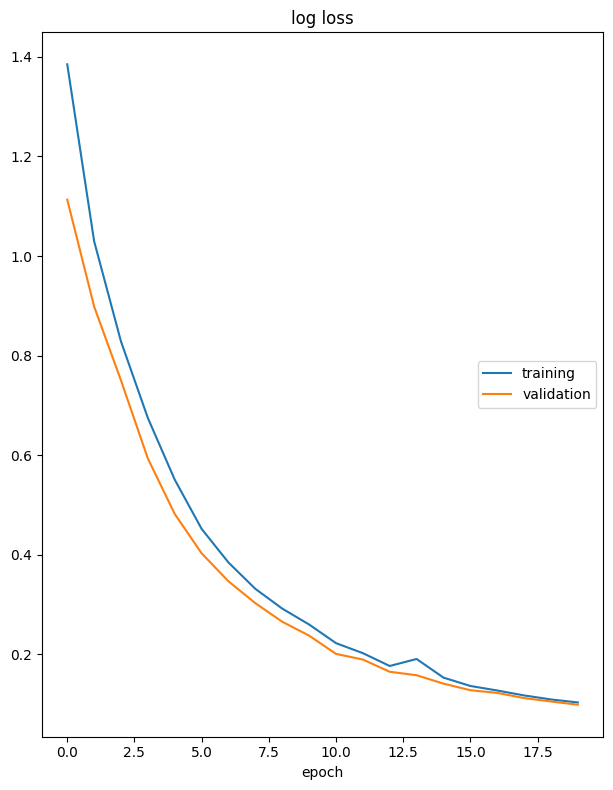

100%|██████████| 20/20 [07:18<00:00, 21.92s/it]

log loss
	training         	 (min:    0.103, max:    1.385, cur:    0.103)
	validation       	 (min:    0.099, max:    1.113, cur:    0.099)


In [211]:
from tqdm import tqdm

liveloss = PlotLosses()
for i in tqdm(range(nepochs)):
    train_loss = train(unet, optimiser, mseloss, train_loader)
    valid_loss = valid(unet, mseloss, val_loader)

    # Liveloss plot
    logs = {}
    logs['' + 'log loss'] = train_loss.item()
    logs['val_' + 'log loss'] = valid_loss.item()
    liveloss.update(logs)
    liveloss.draw()

In [212]:
model_save_name = 'unet_seis_class_lr_5e-4_wd_5e-4_ep_20_clw_augmented.pt'           # .pt and .pth are common file extensions for saving models in pytorch
path = f"/content/drive/MyDrive/models/{model_save_name}" # use this to store in your Google Drive storage
# path = f'./{model_save_name}'                               # use this to store locally (it will be erased once the colab session is over)
torch.save(unet.state_dict(), path)

In [213]:
# get the test dataset and labels
test_dataset = SeismicSliceDataset(seismic_path='data/test_once/test1_seismic.npy', labels_path='data/test_once/test1_labels.npy', mode="both")

test_sampler = DirectionBatchSampler(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader   = DataLoader(dataset=test_dataset, batch_sampler=test_sampler, num_workers=2)

In [214]:
len(test_loader)

112

In [215]:
def collect_for_plot(model, data_loader, device, n_batches=1):
    model.eval()
    collected = []
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            X, y = batch[0], batch[1]
            logits = model(X.to(device)).cpu()
            pred = torch.argmax(logits, dim=1)

            collected.append((X.cpu(), y.cpu(), pred))
            if i + 1 >= n_batches:
                break
    return collected

In [216]:
samples = collect_for_plot(unet, test_loader, device, n_batches=1)
samples[0][0].shape, samples[0][1].shape, samples[0][2].shape

(torch.Size([8, 1, 701, 255]),
 torch.Size([8, 701, 255]),
 torch.Size([8, 701, 255]))

In [217]:
y_true = samples[0][1]
y_pred = samples[0][2]

In [218]:
import builtins
import torch
import matplotlib.pyplot as plt
from itertools import islice

def plot_segmentation_batch(
    model,
    data_loader,
    device,
    batch_idx=0,          # <-- NEW
    n_classes=6,
    n_samples=4,
    cmap_seis="seismic",
    cmap_label="tab20",
    show_confidence=True,
    vmax_seis=None
):
    model.eval()

    # get the batch at batch_idx
    try:
        batch = next(islice(iter(data_loader), batch_idx, None))
    except StopIteration:
        raise ValueError(f"batch_idx={batch_idx} out of range for data_loader")

    if len(batch) == 2:
        X, y = batch
        direction = None
    else:
        X, y, direction = batch

    if y.ndim == 4:
        y = y.squeeze(1)

    with torch.no_grad():
        logits = model(X.to(device)).cpu()
        pred = torch.argmax(logits, dim=1)

        if show_confidence:
            probs = torch.softmax(logits, dim=1)
            conf = probs.max(dim=1).values

    B = X.shape[0]
    n = builtins.min(int(n_samples), int(B))
    ncols = 4 if show_confidence else 3

    fig, axes = plt.subplots(n, ncols, figsize=(4*ncols, 3*n))
    if n == 1:
        axes = [axes]

    for i in range(n):
        x_i = X[i, 0]
        y_i = y[i]
        p_i = pred[i]

        dir_str = "" if direction is None else f"{direction[i]}"
        dir_str = " Inline" if dir_str == "i" else " Cross Line" if dir_str == "x" else dir_str

        ax = axes[i][0]
        im0 = ax.imshow(x_i.permute(1, 0), cmap=cmap_seis, aspect="auto", vmax=vmax_seis)
        ax.set_title(f"Seismic{dir_str}")
        ax.axis("off")
        plt.colorbar(im0, ax=ax, fraction=0.046, pad=0.04)

        ax = axes[i][1]
        im1 = ax.imshow(y_i.permute(1, 0), cmap=cmap_label, aspect="auto",
                         vmin=0, vmax=n_classes-1)
        ax.set_title(f"Ground Truth{dir_str}")
        ax.axis("off")
        plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

        ax = axes[i][2]
        im2 = ax.imshow(p_i.permute(1, 0), cmap=cmap_label, aspect="auto",
                         vmin=0, vmax=n_classes-1)
        ax.set_title(f"Prediction{dir_str}")
        ax.axis("off")
        plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

        if show_confidence:
            ax = axes[i][3]
            im3 = ax.imshow(conf[i].permute(1, 0), aspect="auto")
            ax.set_title(f"Confidence{dir_str}")
            ax.axis("off")
            plt.colorbar(im3, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


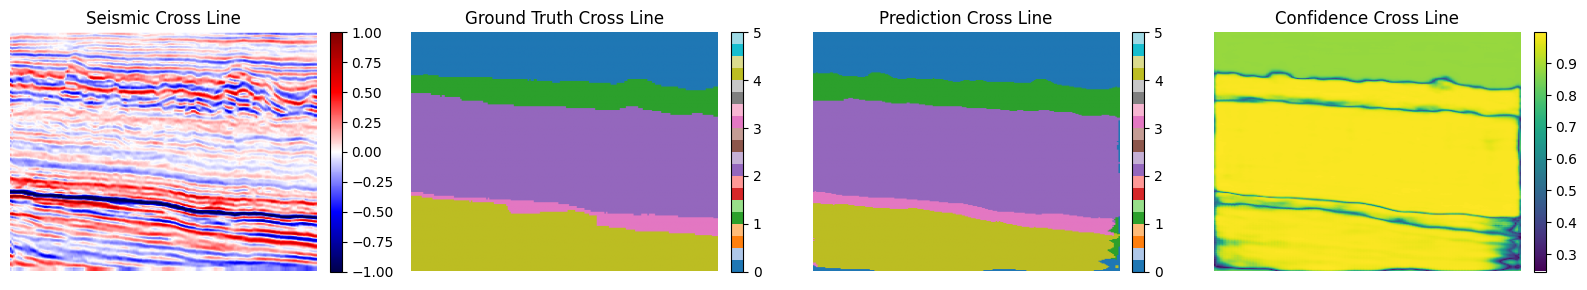

In [226]:
plot_segmentation_batch(
    model=unet,
    data_loader=test_loader,
    device=device,
    batch_idx=60,     # <-- plot 6th batch
    n_samples=1
)


In [227]:
import numpy as np
import torch

def evaluate_metrics_streaming(model, data_loader, device, n_classes=6):
    model.eval()
    hist = np.zeros((n_classes, n_classes), dtype=np.float64)

    def fast_hist(label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        return np.bincount(
            n_class * label_true[mask] + label_pred[mask],
            minlength=n_class**2
        ).reshape(n_class, n_class)

    with torch.no_grad():
        for batch in data_loader:
            X, y = batch[0], batch[1]      # works whether batch has (X,y) or (X,y,dir)
            X = X.to(device)
            y = y.to(device)
            if y.ndim == 4:
                y = y.squeeze(1)

            logits = model(X)
            pred = torch.argmax(logits, dim=1)

            lt = y.detach().cpu().numpy().astype(np.int64)
            lp = pred.detach().cpu().numpy().astype(np.int64)

            for t, p in zip(lt, lp):
                hist += fast_hist(t.flatten(), p.flatten(), n_classes)

    # metrics (same as runningScore)
    acc = np.diag(hist).sum() / (hist.sum() + 1e-12)
    acc_cls = np.diag(hist) / (hist.sum(axis=1) + 1e-12)
    mean_acc_cls = np.nanmean(acc_cls)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist) + 1e-12)
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / (hist.sum() + 1e-12)
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()

    scores = {
        "Pixel Acc: ": float(acc),
        "Class Accuracy: ": acc_cls,
        "Mean Class Acc: ": float(mean_acc_cls),
        "Freq Weighted IoU: ": float(fwavacc),
        "Mean IoU: ": float(mean_iu),
        "confusion_matrix": hist
    }
    cls_iou = dict(zip(range(n_classes), iu))
    return scores, cls_iou

In [237]:
scores_1, cls_iou_1 = evaluate_metrics_streaming(
    model=unet,
    data_loader=test_loader,
    device=device,
    n_classes=6
)

# display the scores and cls_iou neatly like a table

print(f"Pixel Acc: {scores_1["Pixel Acc: "]}")
print("Class Acc: ")
for i in range(scores_1["Class Accuracy: "].shape[0]):
    print(f"Class {i} Acc: {scores_1["Class Accuracy: "][i]}")
print(f"Mean Class Acc: {scores_1["Mean Class Acc: "]}")
print(f"Freq Weighted IoU: {scores_1["Freq Weighted IoU: "]}")
print(f"Mean IoU: {scores_1["Mean IoU: "]}")
print("Per-class IoU:")
for k, v in cls_iou_1.items():
    print(f"Class {k} IoU: {v}")

Pixel Acc: 0.8591499538474449
Class Acc: 
Class 0 Acc: 0.9810065241127582
Class 1 Acc: 0.9347975735743196
Class 2 Acc: 0.9275581418602634
Class 3 Acc: 0.8379118316780734
Class 4 Acc: 0.5266543518809241
Class 5 Acc: 0.6773751092685386
Mean Class Acc: 0.8142172553958128
Freq Weighted IoU: 0.7618576226150794
Mean IoU: 0.6691322550339437
Per-class IoU:
Class 0 IoU: 0.6882442781800142
Class 1 IoU: 0.7847766576866255
Class 2 IoU: 0.9066140309535126
Class 3 IoU: 0.7005464569035812
Class 4 IoU: 0.5103509563572832
Class 5 IoU: 0.4242611501226452


In [238]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names=None, normalize=False):
    """
    cm : ndarray (C,C)
    normalize : if True, normalize rows (GT-wise)
    """

    if normalize:
        cm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, cmap="viridis")

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title("Confusion Matrix" + (" (Normalized)" if normalize else ""))

    if class_names is not None:
        ax.set_xticks(range(len(class_names)))
        ax.set_yticks(range(len(class_names)))
        ax.set_xticklabels(class_names, rotation=45, ha="right")
        ax.set_yticklabels(class_names)

    # write values inside cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            txt = f"{val:.2f}" if normalize else f"{int(val)}"
            ax.text(j, i, txt, ha="center", va="center",
                    color="white" if val > cm.max()/2 else "black")

    plt.tight_layout()
    plt.show()


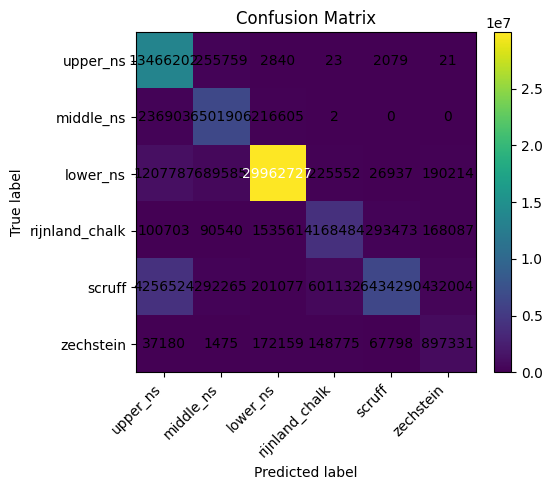

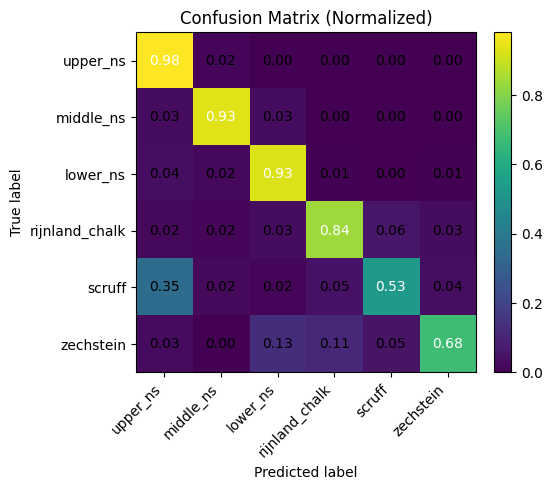

In [244]:
class_names = ['upper_ns', 'middle_ns', 'lower_ns',
                   'rijnland_chalk', 'scruff', 'zechstein']

cm_1 = scores_1["confusion_matrix"]
plot_confusion_matrix(cm_1, class_names=class_names, normalize=False)
plot_confusion_matrix(cm_1, class_names=class_names, normalize=True)

In [240]:
test_dataset_2 = SeismicSliceDataset(seismic_path='data/test_once/test2_seismic.npy', labels_path='data/test_once/test2_labels.npy', mode="both")
test_sampler_2 = DirectionBatchSampler(
    test_dataset_2,
    batch_size=batch_size,
    shuffle=False
)

test_loader_2   = DataLoader(dataset=test_dataset_2, batch_sampler=test_sampler_2, num_workers=2)

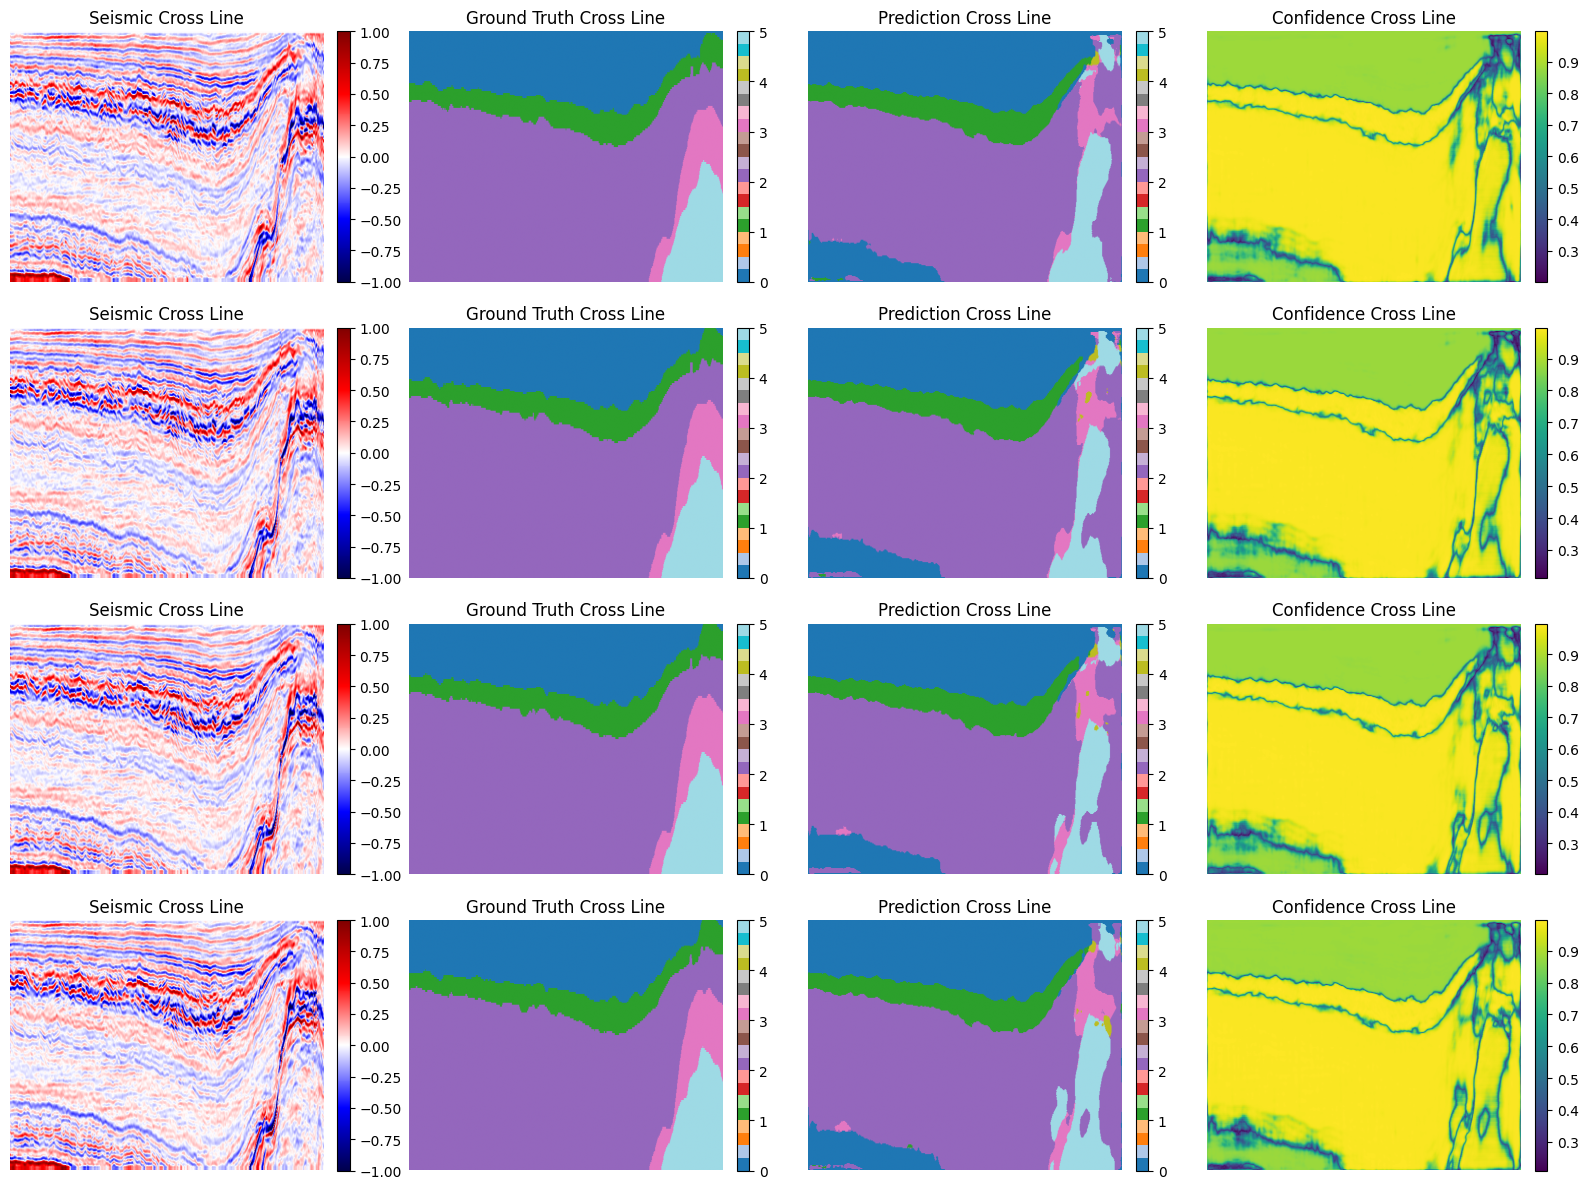

In [241]:
plot_segmentation_batch(
    model=unet,
    data_loader=test_loader_2,
    device=device,
    batch_idx=100,     # <-- plot 6th batch
    n_samples=4
)


In [242]:
scores_2, cls_iou_2 = evaluate_metrics_streaming(
    model=unet,
    data_loader=test_loader_2,
    device=device,
    n_classes=6
)

# display the scores_2 and cls_iou_2 neatly like a table

print(f"Pixel Acc: {scores_2["Pixel Acc: "]}")
print("Class Acc: ")
for i in range(scores_2["Class Accuracy: "].shape[0]):
    print(f"Class {i} Acc: {scores_2["Class Accuracy: "][i]}")
print(f"Mean Class Acc: {scores_2["Mean Class Acc: "]}")
print(f"Freq Weighted IoU: {scores_2["Freq Weighted IoU: "]}")
print(f"Mean IoU: {scores_2["Mean IoU: "]}")
print("Per-class IoU:")
for k, v in cls_iou_2.items():
    print(f"Class {k} IoU: {v}")

Pixel Acc: 0.9031568301197351
Class Acc: 
Class 0 Acc: 0.9664590279257231
Class 1 Acc: 0.9124816355412635
Class 2 Acc: 0.9241165858004761
Class 3 Acc: 0.5585897784387472
Class 4 Acc: 0.45745007808087185
Class 5 Acc: 0.6275198649126064
Mean Class Acc: 0.741102828449948
Freq Weighted IoU: 0.8426451212486504
Mean IoU: 0.5986570966595804
Per-class IoU:
Class 0 IoU: 0.8754062888316495
Class 1 IoU: 0.8173544320160773
Class 2 IoU: 0.8977427325369584
Class 3 IoU: 0.4830156537363019
Class 4 IoU: 0.17766991622448
Class 5 IoU: 0.34075355661201595


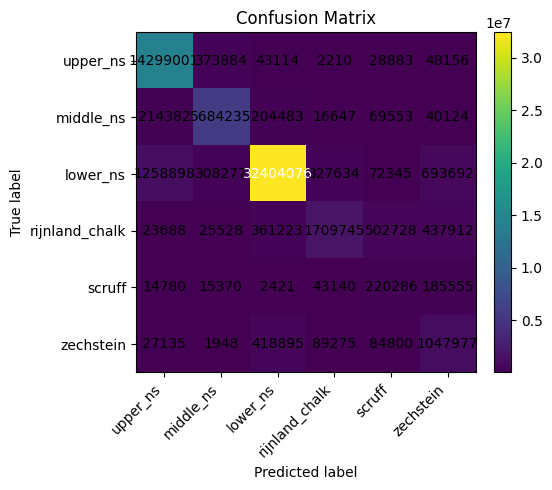

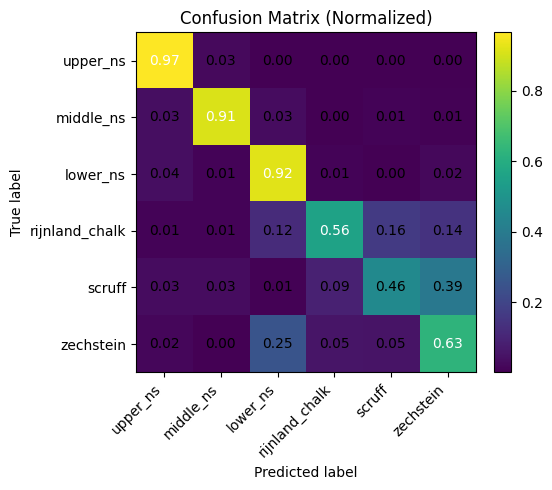

In [243]:
cm_2 = scores_2["confusion_matrix"]
plot_confusion_matrix(cm_2, class_names=class_names, normalize=False)
plot_confusion_matrix(cm_2, class_names=class_names, normalize=True)

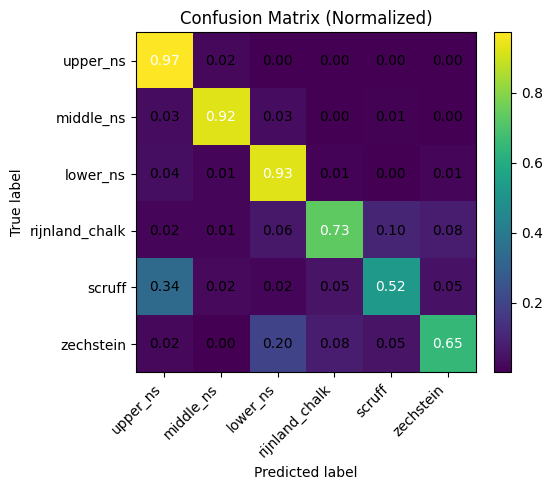

In [245]:
cm = cm_1 + cm_2
plot_confusion_matrix(cm, class_names=class_names, normalize=True)

In [246]:
def plot_sample_by_index(model, dataset, device, idx, n_classes=6):
    model.eval()

    item = dataset[idx]
    if len(item) == 2:
        x, y = item
        direction = None
    else:
        x, y, direction = item

    x = x.unsqueeze(0).to(device)
    if y.ndim == 3:
        y = y.squeeze(0)

    with torch.no_grad():
        logits = model(x).cpu()
        pred = torch.argmax(logits, dim=1)[0]

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    axs[0].imshow(x[0,0].cpu().permute(1,0), cmap="seismic", aspect="auto")
    axs[0].set_title("Seismic")
    axs[1].imshow(y.permute(1,0), cmap="tab20", vmin=0, vmax=n_classes-1)
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred.permute(1,0), cmap="tab20", vmin=0, vmax=n_classes-1)
    axs[2].set_title("Prediction")
    for ax in axs:
        ax.axis("off")
    plt.show()


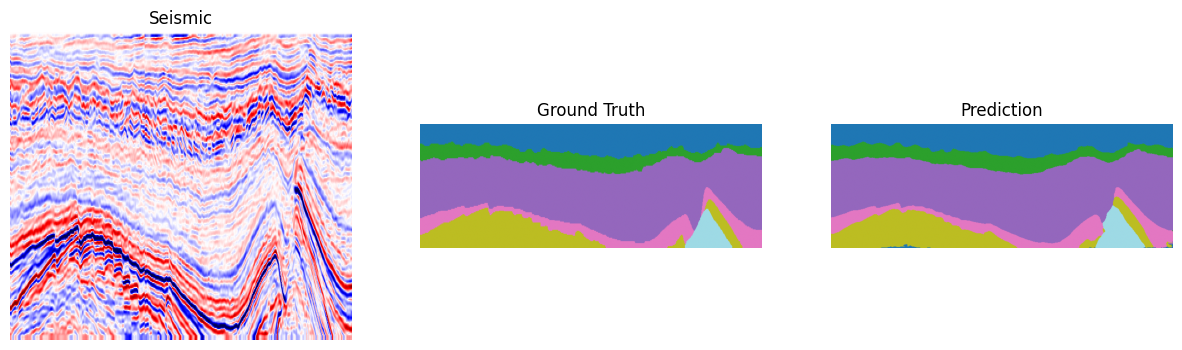

In [269]:
plot_sample_by_index(unet, test_dataset, device, idx=199)

In [249]:
len(test_dataset)

901

In [260]:
test_dataset[200][0].shape

torch.Size([1, 200, 255])

In [262]:
print("len:", len(test_dataset))
print("index_map[200]:", test_dataset.index_map[199])


len: 901
index_map[200]: ('i', 199)


In [261]:
test_dataset.index_map

[('i', 0),
 ('i', 1),
 ('i', 2),
 ('i', 3),
 ('i', 4),
 ('i', 5),
 ('i', 6),
 ('i', 7),
 ('i', 8),
 ('i', 9),
 ('i', 10),
 ('i', 11),
 ('i', 12),
 ('i', 13),
 ('i', 14),
 ('i', 15),
 ('i', 16),
 ('i', 17),
 ('i', 18),
 ('i', 19),
 ('i', 20),
 ('i', 21),
 ('i', 22),
 ('i', 23),
 ('i', 24),
 ('i', 25),
 ('i', 26),
 ('i', 27),
 ('i', 28),
 ('i', 29),
 ('i', 30),
 ('i', 31),
 ('i', 32),
 ('i', 33),
 ('i', 34),
 ('i', 35),
 ('i', 36),
 ('i', 37),
 ('i', 38),
 ('i', 39),
 ('i', 40),
 ('i', 41),
 ('i', 42),
 ('i', 43),
 ('i', 44),
 ('i', 45),
 ('i', 46),
 ('i', 47),
 ('i', 48),
 ('i', 49),
 ('i', 50),
 ('i', 51),
 ('i', 52),
 ('i', 53),
 ('i', 54),
 ('i', 55),
 ('i', 56),
 ('i', 57),
 ('i', 58),
 ('i', 59),
 ('i', 60),
 ('i', 61),
 ('i', 62),
 ('i', 63),
 ('i', 64),
 ('i', 65),
 ('i', 66),
 ('i', 67),
 ('i', 68),
 ('i', 69),
 ('i', 70),
 ('i', 71),
 ('i', 72),
 ('i', 73),
 ('i', 74),
 ('i', 75),
 ('i', 76),
 ('i', 77),
 ('i', 78),
 ('i', 79),
 ('i', 80),
 ('i', 81),
 ('i', 82),
 ('i', 83),
 (